# Softmax

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import os


## Softmax-Funktion

Die Softmax-Funktion ist eine mathematische Funktion, die in der Regel in der letzten Schicht eines neuronalen Netzwerks verwendet wird, insbesondere bei Klassifikationsproblemen. Sie nimmt einen Vektor von Rohwerten (Logits) und transformiert ihn in einen Vektor von Wahrscheinlichkeiten, wobei die Summe aller Wahrscheinlichkeiten gleich 1 ist.

Gegeben sei ein Vektor von Ausgaben des neuronalen Netzwerkes $ z = (z_1, z_2, \ldots, z_n) $,
Die Funktion wird wie folgt definiert:
$$
\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j} e^{z_j}}
$$

In Worten ausgedrückt: Für jedes Element $ z_i $ im Vektor $ z $ berechnet die Softmax-Funktion den Exponentialwert von $ z_i $ und teilt diesen durch die Summe der Exponentialwerte aller Elemente im Vektor.


**Vorteile der Softmax-Funktion:**
- **Wahrscheinlichkeitsverteilung**: Die Softmax-Funktion transformiert die Ausgaben des Modells in eine Wahrscheinlichkeiten, was es einfacher macht, die Vorhersagen zu interpretieren.
- **Ableitbarkeit**: Die Softmax-Funktion ist ableitbar, was es ermöglicht, sie in Backpropagation zu verwenden, um die Gewichte des Modells zu aktualisieren.

### Torch vorbereiten

In [3]:
# Wir prüfen ob eine Hardwarebeschleunigung möglich ist und verwenden diese, wenn sie verfügbar ist
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
torch.manual_seed(42) # Setze den Zufallsseed für Reproduzierbarkeit
print(f"Using {device} device")

Using cpu device


## MNIST Dataset vorbereiten, laden und visualisieren

Wir nutzen für dieses Notebook den MNIST-Datensatz, der handgeschriebene Ziffern enthält. Die Ziffern sind in 10 Klassen (0-9) unterteilt, und jede Klasse enthält Tausende von Bildern. 
Die Bilder sind in Graustufen und haben eine Auflösung von 28x28 Pixeln.
Das Modell muss lernen, diese Ziffern korrekt zu klassifizieren.

Wir werden diesen Datensatz laden, vorbereiten und einige Beispiele visualisieren. Der Datensatz kann direkt von PyTorch heruntergeladen werden, was den Prozess vereinfacht.

Quelle Dataset: [MNIST Dataset](https://pytorch.org/vision/stable/datasets.html#mnist)

Originale nicht mehr existierende Webseite: [MNIST Dataset](http://yann.lecun.com/exdb/mnist/)

In [4]:
# Mnist Dataset laden
mnist_train = torchvision.datasets.MNIST(root='datasets', train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root='datasets', train=False, download=True)

# Damit wir die Bilder in einem CNN verwenden können, müssen wir die Bilder in Tensoren umwandeln.

transform = torchvision.transforms.ToTensor()

# Mit der Bibliothek Torchvision können wird das MNIST Dataset direkt herunterladen und in einem Schritt in Tensoren umwandeln. 
# Train=True lädt den Trainingsdatensatz, Train=False lädt den Testdatensatz.
mnist_transformed_train = torchvision.datasets.MNIST(root='datasets', train=True, download=True, transform=transform)
mnist_transformed_test = torchvision.datasets.MNIST(root='datasets', train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_transformed_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_transformed_test, batch_size=64, shuffle=True)

### Modell erstellen

In [5]:
# TODO erstellen Sie mit torch.nn.sequential ein Convolutional Neural Network mit folgenden Schichten. Die Schichten werden als einzelne Parameter an torch.nn.Sequential übergeben.
# - Convolutional Layer mit einem Eingabe-Kanal, 12 Ausgabekanälen, einem Kernel von 7x7, einem Stride von 1 und einem Padding von 0
# - Max Pooling Layer mit einem Kernel von 2x2 und einem Stride von 2
# - RELU Aktivierungsfunktion
# - Convolutional Layer mit 12 Eingabekanälen, 16 Ausgabekanälen, einem Kernel von 5x5, einem Stride von 1 und einem Padding von 2
# - Max Pooling Layer mit einem Kernel von 2x2 und einem Stride von 2
# - RELU Aktivierungsfunktion
# - Flatten Layer, um die Daten für die Fully Connected Layer vorzubereiten
# - Fully Connected Layer mit der Anzahl Eingabeneuronen die Sie oben berechnet haben und 10 Ausgabeneuronen.

model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=12, kernel_size=7, stride=1, padding=0),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=12, out_channels=16, kernel_size=5, stride=1, padding=2),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=16*5*5, out_features=10),
)

### Netzwerk trainieren

In [6]:
# Testen ob das File für das Modell existiert und das Modell geladen werden kann, ansonsten wird das Modell trainiert und gespeichert.
if os.path.exists("mnist_cnn.pth"):
    model.load_state_dict(torch.load("mnist_cnn.pth"))
    print("Modell erfolgreich geladen!")
else:
    # Hyperparameter definieren
    max_num_epochs = 10
    learning_rate = 0.001
    momentum = 0.9

    # Optimizer und die Loss-Funktion definieren
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    loss = torch.nn.CrossEntropyLoss()

    train_losses = []
    test_losses = []

    # Das Modell muss noch auf die Hardware verschoben werden.
    model.to(device)

    for epoch in range(max_num_epochs):
        batch_train_losses = []
        batch_test_losses = []
        for batch in train_loader:
            images, labels = batch

            # Wir verschieben die Bilder und Labels auf die gleiche Hardware wie das Modell (CPU oder GPU)
            images, labels = images.to(device), labels.to(device)

            # TODO vervollständigen Sie hier die nötigen Schritte, um das Modell zu trainieren
            optimizer.zero_grad()
            outputs = model(images)

            train_loss = loss(outputs, labels)
            train_loss.backward()
            optimizer.step()
            batch_train_losses.append(train_loss.item())

        with torch.no_grad():
            for batch in test_loader:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                batch_test_losses.append(loss(outputs, labels).item())

        training_loss = np.mean(batch_train_losses)
        testing_loss = np.mean(batch_test_losses)
        train_losses.append(training_loss)
        test_losses.append(testing_loss)

        print(f"Epoch {epoch}: Train Loss = {training_loss:.5f}, Test Loss = {testing_loss:.5f}")

    # Modell speichern
    torch.save(model.state_dict(), 'mnist_cnn.pth')



Modell erfolgreich geladen!


### Aufgabe 1: Ausgaben des Modells interpretieren

Die "Roh-Ausgaben" eines Modells werden Logits genannt. Sie sind die direkten Ausgaben der letzten Schicht eines neuronalen Netzwerks, bevor z.B. eine Softmax-Funktion angewendet wird. Logits können positive oder negative Werte annehmen und geben an, wie stark das Modell glaubt, dass ein bestimmtes Bild zu einer bestimmten Klasse gehört. Je höher der Logit-Wert, desto stärker ist die Vorhersage für diese Klasse.


1. Inspizieren Sie die Ausgaben des Modells für das erste Bild im Batch. Was stellen diese Werte dar? Wie können sie interpretiert werden?
> Die Ausgaben des Modells für das erste Bild im Batch sind Rohwerte (Logits), die die Vorhersage des Modells für jede Klasse darstellen. Diese Werte können positiv oder negativ sein und geben an, wie stark das Modell glaubt, dass das Bild zu einer bestimmten Klasse gehört. Je höher der Wert, desto stärker ist die Vorhersage für diese Klasse.

Das Label für das Sample ist: 0

Vorhersage für Klasse 0: 12.608152
Vorhersage für Klasse 1: -6.236690
Vorhersage für Klasse 2: 3.197339
Vorhersage für Klasse 3: 0.772621
Vorhersage für Klasse 4: -7.354732
Vorhersage für Klasse 5: 4.298587
Vorhersage für Klasse 6: -3.331713
Vorhersage für Klasse 7: 0.362355
Vorhersage für Klasse 8: -1.456438
Vorhersage für Klasse 9: -0.462912


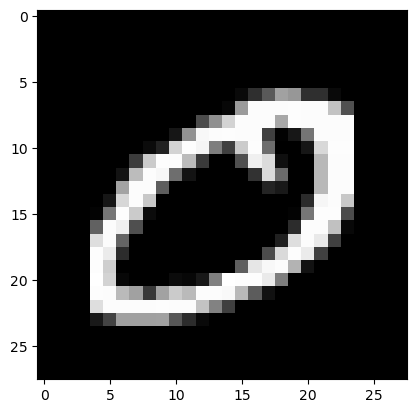

In [24]:
# Batch aus dem Testloader nehmen und die Ausgaben des Modells für diesen Batch berechnen. Wir verwenden hier den Testloader, damit wir die Ausgaben des Modells mit den Labels vergleichen können.
with torch.no_grad():
    for image, target in test_loader:
        image, target = image.to(device), target.to(device)
        outputs = model(image)
        break

print(f"Das Label für das Sample ist: {target[0].item()}\n") 

# Outputs für das erste Bild im Batch
for i in range(10):
    print(f"Vorhersage für Klasse {i}: {outputs[0][i].item():5f}")

# Bild anzeigen
plt.imshow(image[0].cpu().squeeze(), cmap='gray')
plt.show()

### Aufgabe 2: Softmax anwenden

1. Wir wenden die Softmax-Funktion auf die Ausgaben des Modells anwenden, um die Wahrscheinlichkeiten für jede Klasse zu berechnen. Welcher Wert im Vergleich zu den Ausgabewerten (Logits) in Aufgabe 1 hat die höchste Wahrscheinlichkeit? 
> Der höchste Ausgabewert (Logit) aus Aufgabe 1 hat die höchste Wahrscheinlichkeit.

2. Wie verhalten sich die Wahrscheinlichkeiten der anderen Klassen im Vergleich dazu? Ist das Verhältnis der Unterschiede zwischen den Logit-Werten und den Wahrscheinlichkeiten der Klassen intuitiv verständlich?
> Die Wahrscheinlichkeiten der anderen Klassen sind im Vergleich zum höchsten Logit-Wert deutlich niedriger, da die Softmax-Funktion die Werte exponentiell transformiert und normalisiert. Daher wird die Klasse mit dem höchsten Logit-Wert eine viel höhere Wahrscheinlichkeit haben als die anderen Klassen.

In [25]:
print(f"Das Label für das Sample ist: {target[0].item()}\n") 

softmax = torch.nn.Softmax(dim=0)
probabilities = softmax(outputs[0])
probabilities = probabilities.cpu().numpy().round(7)
for i in range(10):
    print(f"Wahrscheinlichkeit Klasse {i}: {probabilities[i]:.7f}")

Das Label für das Sample ist: 0

Wahrscheinlichkeit Klasse 0: 0.9996570
Wahrscheinlichkeit Klasse 1: 0.0000000
Wahrscheinlichkeit Klasse 2: 0.0000818
Wahrscheinlichkeit Klasse 3: 0.0000072
Wahrscheinlichkeit Klasse 4: 0.0000000
Wahrscheinlichkeit Klasse 5: 0.0002461
Wahrscheinlichkeit Klasse 6: 0.0000001
Wahrscheinlichkeit Klasse 7: 0.0000048
Wahrscheinlichkeit Klasse 8: 0.0000008
Wahrscheinlichkeit Klasse 9: 0.0000021


## Hintergrundinformation: Weshalb Softmax im Modell-Training nicht verwendet wird

Der Grund, warum die Softmax-Funktion im Modell-Training nicht direkt verwendet wird, liegt darin, dass die meisten Verlustfunktionen für Klassifikationsprobleme, wie z.B. die Kreuzentropie-Verlustfunktion, bereits die Softmax-Funktion intern anwenden. Somit müssen wir die Softmax-Funktion nicht explizit in unserem Modell verwenden, da sie bereits in der Verlustfunktion berücksichtigt wird.